# Showcase that different configurations lead to highly correlated results

In [1]:
%load_ext lab_black
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from IPython.display import display, Markdown, Latex
import scipy
import matplotlib.transforms as mtrans
import string
from scipy.stats import pearsonr, spearmanr
from os.path import join
from tqdm import tqdm

In [2]:
SCORE_DIR = (
    f"/n/holyscratch01/price_lab/khou/continuous_weights_experiment/full_score_file"
)


URL_SUPP_TABLE = "https://www.dropbox.com/s/k4tkz981t4x1km5/supp-tables.xlsx?dl=1"

df_trait_info = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name=0,
)
trait_list = df_trait_info["Trait_Identifier"].values

In [3]:
gwas_weight_list = (
    [f"top-{n}" for n in [100, 500, 1000, 2000]]
    + [f"fdr1-{n}" for n in [2000]]
    + [f"fwer5-{n}" for n in [2000]]
)
gwas_weight_list = [
    f"{m}-{w}" for m, w in itertools.product(gwas_weight_list, ["zscore", "uniform"])
]
method_list = [
    f"{m}.{w}" for m, w in itertools.product(gwas_weight_list, ["uniform", "vs"])
]

method_list += [
    f"{m}.{w}"
    for m, w in itertools.product(
        [f"top{window}kb-1000-zscore" for window in [0, 10, 50]], ["uniform", "vs"]
    )
]

method_list = sorted(
    list(
        set(
            [method for method in method_list if method.startswith("top-1000-")]
            + [method for method in method_list if method.endswith("-zscore.vs")]
            + [method for method in method_list if "kb" in method]
        )
    )
)

In [4]:
dict_score_df = dict()
for method in tqdm(method_list):
    dict_df = dict()
    for trait in trait_list:
        df_temp = pd.read_csv(
            join(SCORE_DIR, method, f"{trait}.score.gz"), sep="\t", index_col=0
        )
        dict_df[trait] = df_temp["zscore"]
    df_trs_zsc = pd.DataFrame(dict_df)
    dict_score_df[method] = df_trs_zsc

100%|██████████| 15/15 [05:08<00:00, 20.57s/it]


In [5]:
df_baseline = dict_score_df["top-1000-zscore.vs"]

# correlation
dict_zsc_cor = {}
for method in method_list:
    list_cor = [
        pearsonr(df_baseline[trait], dict_score_df[method][trait])[0]
        for trait in df_baseline
    ]
    dict_zsc_cor[method] = list_cor

In [6]:
groups_list = [
    [
        w + "-zscore.vs"
        for w in ["top-100", "top-500", "top-2000", "fdr1-2000", "fwer5-2000"]
    ],  # varying gene set
    [
        "top-1000-" + w for w in ["uniform.uniform", "zscore.uniform", "uniform.vs"]
    ],  # varying single cell weights
    [f"top{w}kb-1000-zscore.vs" for w in [0, 50]],  # varying kb window
]
labels_list = [
    ["Top 100", "Top 500", "Top 2,000", "FWER < 5%", "FDR < 1%"],
    ["Unweighted", "GWAS Z", "single-cell VS"],
    ["0kb", "50kb"],
]

title_list = [
    "GWAS Z + single-cell VS\n10kb window",
    "Top 1,000 genes\n10kb window",
    "GWAS Z + single-cell VS\nTop 1,000 genes",
]

medians of correlation to top-100-zscore.vs: 0.49
medians of correlation to top-500-zscore.vs: 0.84
medians of correlation to top-2000-zscore.vs: 0.88
medians of correlation to fdr1-2000-zscore.vs: 0.86
medians of correlation to fwer5-2000-zscore.vs: 0.8


medians of correlation to top-1000-uniform.uniform: 0.87
medians of correlation to top-1000-zscore.uniform: 0.89
medians of correlation to top-1000-uniform.vs: 0.98


medians of correlation to top0kb-1000-zscore.vs: 0.89
medians of correlation to top50kb-1000-zscore.vs: 0.88




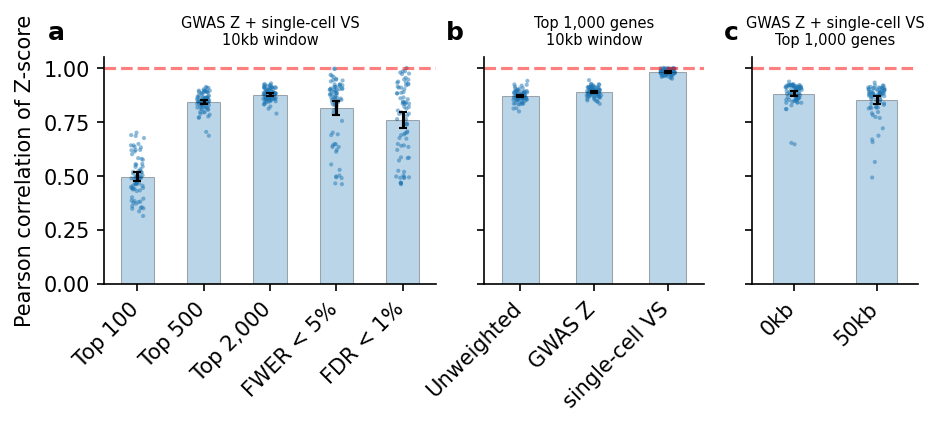

In [38]:
fig, axes = plt.subplots(
    figsize=(7, 2),
    dpi=150,
    ncols=3,
    sharey=True,
    gridspec_kw={"width_ratios": [6, 4, 3]},
)

########################
# compare gene selection
########################

for ax_i in range(3):
    ax = axes[ax_i]
    groups, labels = groups_list[ax_i], labels_list[ax_i]

    print(
        "\n".join(
            [
                f"medians of correlation to {g}: {np.median(dict_zsc_cor[g]):.2g}"
                for g in groups
            ]
        )
    )
    print("\n")
    mean = [np.mean(dict_zsc_cor[g]) for g in groups]
    se = [np.std(dict_zsc_cor[g]) / np.sqrt(len(dict_zsc_cor[g])) for g in groups]

    barplot = ax.bar(
        np.arange(len(mean)),
        mean,
        yerr=np.array(se) * 2,
        align="center",
        alpha=0.3,
        color="C0",
        ecolor="black",
        edgecolor="black",
        linewidth=0.5,
        capsize=2,
        width=0.5,
    )
    sns.stripplot(
        x=np.repeat(np.arange(len(groups)), [len(dict_zsc_cor[g]) for g in groups]),
        y=np.concatenate([dict_zsc_cor[g] for g in groups]),
        color="C0",
        alpha=0.5,
        s=2,
        zorder=-10,
        ax=ax,
    )
    ax.set_xticks(np.arange(len(mean)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_title(title_list[ax_i], fontsize=7)

    # annotation
    ax.text(
        -0.17,
        1.08,
        string.ascii_lowercase[ax_i],
        transform=ax.transAxes,
        size=12,
        weight="bold",
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    trans = mtrans.Affine2D().translate(5, 0)
    for t in ax.get_xticklabels():
        t.set_transform(t.get_transform() + trans)

    ax.axhline(y=1, ls="--", color="r", alpha=0.5)

axes[0].set_ylabel(
    "Pearson correlation of Z-score",
    fontsize=10,
)
# plt.tight_layout()
plt.savefig("results/geneset_zsc_cor.pdf", bbox_inches="tight")